In [21]:
from model import train_crm
from huggingface_hub import hf_hub_download
import json
from util.utils import get_tri
from PIL import Image
import nvdiffrast.torch as dr
import torch
import tqdm
import numpy as np
import kaolin as kal
from matplotlib import pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import render
import loss
from util_flexi import *

In [22]:
iter = 1000
batch = 8
train_res = [1024, 1024]
voxel_grid_res = 64
device = 'cuda'
sdf_regularizer = 0.2
path_to_images = "Data/shoe0"

In [23]:
crm_path = hf_hub_download(repo_id="Zhengyi/CRM", filename="CRM.pth")
specs = json.load(open("configs/specs_objaverse_total.json"))

model_crm = train_crm(specs).to('cuda:0')
model_crm.load_state_dict(torch.load(crm_path, map_location = device), strict=False)

fc = model_crm.renderer.flexicubes
grid_edges = fc.all_edges

add gt mesh


In [24]:
gt_mesh = kal.io.obj.import_mesh(f'Data/gtShoe/shoe_0.obj').cuda()
vertices = gt_mesh.vertices
vmin, vmax = vertices.min(dim=0)[0], vertices.max(dim=0)[0]
scale = 1.8 / torch.max(vmax - vmin).item()
vertices = vertices - (vmax + vmin) / 2 # Center mesh on origin
# gt_mesh.vertices = vertices * scale # Rescale to [-0.9, 0.9]

In [25]:
def data_loader(path):
    rgb=[]
    ccm=[]
    for i in range(6):
            rgb_img = Image.open(f'{path}/rgb/{i}.png') #rgb image path
            ccm_img = Image.open(f'{path}/ccm/{i}.png') #ccm image path
            new_width  = 256
            new_height = new_width 
            new_height = 256
            new_width  = new_height 
            pixel_rgb_img = rgb_img.resize((new_width, new_height), Image.LANCZOS)
            pixel_ccm_img = ccm_img.resize((new_width, new_height), Image.LANCZOS)
            rgb_img_arr = np.asarray(pixel_rgb_img)
            rgb_ccm_arr = np.asarray(pixel_ccm_img)
            rgb.append(rgb_img_arr)
            ccm.append(rgb_ccm_arr)

    rgb = [Image.fromarray(img) for img in rgb]
    ccm = [Image.fromarray(img) for img in ccm]
    np_imgs = np.concatenate(rgb, 1)
    np_xyzs = np.concatenate(ccm, 1)

    return(np_imgs,np_xyzs)

option lr schedular

In [26]:
def lr_schedule(iter):
    return max(0.0, 10 ** (-(iter) * 0.0002)) # Exponential falloff from [1.0, 0.1] over 5k epochs.

optimizer = optim.Adam(model_crm.parameters(), lr=1e-4)   

In [27]:
def generate_3d(rgb, ccm,model):
    color_tri = torch.from_numpy(rgb)/255
    xyz_tri = torch.from_numpy(ccm[:,:,(2,1,0)])/255
    color = color_tri.permute(2,0,1)
    xyz = xyz_tri.permute(2,0,1)


    def get_imgs(color):
        # color : [C, H, W*6]
        color_list = []
        color_list.append(color[:,:,256*5:256*(1+5)])
        for i in range(0,5):
            color_list.append(color[:,:,256*i:256*(1+i)])
        return torch.stack(color_list, dim=0)# [6, C, H, W]

    triplane_color = get_imgs(color).permute(0,2,3,1).unsqueeze(0).to(device)# [1, 6, H, W, C]

    color = get_imgs(color)
    xyz = get_imgs(xyz)

    color = get_tri(color, dim=0, blender= True, scale = 1).unsqueeze(0)
    xyz = get_tri(xyz, dim=0, blender= True, scale = 1, fix= True).unsqueeze(0)

    triplane = torch.cat([color,xyz],dim=1).to(device)
    # 3D visualize
    model.eval()
    glctx = dr.RasterizeCudaContext()

    if model.denoising == True:
        tnew = 20
        tnew = torch.randint(tnew, tnew+1, [triplane.shape[0]], dtype=torch.long, device=triplane.device)
        noise_new = torch.randn_like(triplane) *0.5+0.5
        triplane = model.scheduler.add_noise(triplane, noise_new, tnew)    
        # start_time = time.time()
        with torch.no_grad():
            triplane_feature2 = model.unet2(triplane,tnew)
        # end_time = time.time()
        # elapsed_time = end_time - start_time
        # print(f"unet takes {elapsed_time}s")
    else:
        triplane_feature2 = model.unet2(triplane)
        

    with torch.no_grad():
        data_config = {
            'resolution': [1024, 1024],
            "triview_color": triplane_color.to(device),
        }

        result,vert,faces,weight,sdf = model.decode(data_config, triplane_feature2)
        # print(data[1][0])
        data_config['verts'] = vert[0]
        data_config['faces'] = faces
        data_config =  data_config | result
        data_config['weight'] = weight
        data_config['sdf'] = sdf
    return data_config

In [28]:
rgb,ccm = data_loader(path_to_images)
data_config = generate_3d(rgb,ccm,model_crm)
flexicubes_mesh = kal.rep.SurfaceMesh(vertices=data_config['verts'], faces=data_config['faces'].to(torch.int64))
intermediate_results = [flexicubes_mesh]

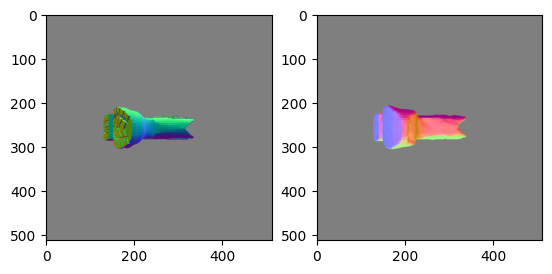

In [29]:
camera = render.get_rotate_camera(0)
f, ax = plt.subplots(1, 2)
output = render.render_mesh(gt_mesh, camera, [512, 512], return_types=['normals'])
ax[0].imshow(((output['normals'][0] + 1) / 2.).cpu().detach())
output = render.render_mesh(flexicubes_mesh, camera, [512, 512], return_types=['normals'])
ax[1].imshow(((output['normals'][0] + 1) / 2.).cpu().detach())
plt.show()

In [30]:
loop = tqdm.tqdm(range(iter),leave=True)
for it in loop: 

    optimizer.zero_grad()
    # sample random camera poses
    cameras = render.get_random_camera_batch(batch, iter_res=train_res, device=device)
    
    # render gt mesh at sampled views
    target = render.render_mesh(gt_mesh, cameras, train_res)

    data_config = generate_3d(rgb,ccm,model_crm)
    
    flexicubes_mesh = kal.rep.SurfaceMesh(vertices=data_config['verts'], faces=data_config['faces'].to(torch.int64))

    buffers = render.render_mesh(flexicubes_mesh, cameras, train_res)

    # evaluate reconstruction loss
    mask_loss = (buffers['mask'] - target['mask']).abs().mean() # mask loss
    depth_loss = (((((buffers['depth'] - (target['depth']))* target['mask'])**2).sum(-1)+1e-8)).sqrt().mean() * 10 # depth loss


    # evaluate regularization losses
    t_iter = it / iter
    # this is the regularization loss described in Equation 2 of the nvdiffrec paper by Munkberg et al., which serves to remove internal floating elements that are not visible to the user.
    sdf_weight = sdf_regularizer - (sdf_regularizer - sdf_regularizer/20)*min(1.0, 4.0 * t_iter)
    sdf = torch.nn.Parameter(data_config['sdf'][0].clone().detach(), requires_grad=True)
    reg_loss = loss.sdf_reg_loss(sdf, grid_edges).mean() * sdf_weight

    reg_loss += data_config["flex_surf_loss"]*0.5 # L_dev as in Equation 8 of our paper
    reg_loss += (data_config["weight"][:,:20]).abs().mean() * 0.1  # regularize weights to be zeros to improve the stability of the optimization process
    total_loss = 0.5*(mask_loss + depth_loss) + 0.005*reg_loss
    

    if True: # optionally add SDF loss to eliminate internal structures
            with torch.no_grad():
                pts = sample_random_points(1000, gt_mesh)
                gt_sdf = compute_sdf(pts, gt_mesh.vertices, gt_mesh.faces)
            pred_sdf = compute_sdf(pts, flexicubes_mesh.vertices, flexicubes_mesh.faces)
            total_loss += torch.nn.functional.mse_loss(pred_sdf, gt_sdf) * 2e3
        
    # optionally add developability regularizer, as described in paper section 5.2
    # if True:
    #     reg_weight = max(0, t_iter - 0.8) * 5
    #     if reg_weight > 0: # only applied after shape converges
    #         reg_loss = loss.mesh_developable_reg(flexicubes_mesh).mean() * 10
    #         reg_loss += (deform).abs().mean()
    #         reg_loss += (weight[:,:20]).abs().mean()
    #         total_loss = mask_loss + depth_loss + reg_loss 
            
    total_loss.backward()
    optimizer.step()
    # scheduler.step()
    if it % 100 == 0:
            log=open('log.txt','a')
            log.write(f'epoch = {it} : loss = {total_loss.item()}\n')
            log.close()

    if it % 1000 == 0:
        log=open('log.txt','a')
        torch.save(model_crm.state_dict(), f'checkpoints/model_weights_1_2_{it}.pth')
        log.write(f'[Saved checkpoint] epoch = {it} : loss = {total_loss.item()}\n')
        log.close()

    if (it + 1) % 20 == 0: # save intermediate results every 100 iters
        with torch.no_grad():
            # run the mesh extraction again with the parameter 'training=False' so that each quadrilateral face is divided into two triangles, as opposed to the four triangles during the training phase.
            data_config = generate_3d(rgb,ccm,model_crm)
            intermediate_results.append(kal.rep.SurfaceMesh(vertices=data_config['verts'], faces=data_config['faces'].to(torch.int64)))

    # update tqdm loop
    loop.set_postfix(loss = total_loss.item())

  2%|▏         | 17/1000 [00:22<21:02,  1.28s/it, loss=3.69] 

In [ ]:
torch.save(model_crm.state_dict(), 'model_weights_final2_lrSH.pth')

In [ ]:
camera = render.get_rotate_camera(0)
render.TimelineVisualizer(intermediate_results, 512, 512).show(camera)